Hello Kushal, my name is Artem. I'm going to review your project!

You can find my comments in <font color='green'>green</font>, <font color='blue'>blue</font> or <font color='red'>red</font> boxes like this:

<div class="alert alert-block alert-success">
<b>Success:</b> if everything is done succesfully
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> "Improve" comments mean that there are tiny corrections that could help you to make your project better.
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> if the block requires some corrections. Work can't be accepted with the red comments.
</div>

### <font color='orange'>General feedback</font>
* I'm glad to say that you executed your project really well.
* Thank you for structuring the project. It's a pleasure to check such notebooks.
* Great that you've mastered bootstrap technique.
* Risk of losses was calculated correctly. Well done!
* There is only one issue. So it would be easy to fix.
* There are few things I'd like you to check. They're not mistakes, but your project could be improved if you correct them.
* While there's room for improvement, on the whole, your project is looking good.
* I believe you can easily fix it! Good luck!

### <font color='orange'>General feedback (review 2)</font>
* New comment is marked with "review 2" keyword.

### <font color='orange'>General feedback (review 3)</font>
* Your corrections look great, you've improved your work significantly!
* Your project has been accepted and you can go to the next sprint!
* Keep up the good work. Good luck next!

# Project Description

You work for the OilyGiant mining company. Your task is to find the best place for a new well.
Steps to choose the location:
- Collect the oil well parameters in the selected region: oil quality and volume of reserves;
- Build a model for predicting the volume of reserves in the new wells;
- Pick the oil wells with the highest estimated values;
- Pick the region with the highest total profit for the selected oil wells.

You have data on oil samples from three regions. Parameters of each oil well in the region are already known. Build a model that will help to pick the region with the highest profit margin. Analyze potential profit and risks using the Bootstrapping technique.

In [1]:
#Adding this first up to make sure we don't need to see warnings to make outputs look nice
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [2]:
#Let us first import the relevant libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from joblib import dump
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy import stats as st

<div class="alert alert-block alert-success">
<b>Success:</b> Thank you for collecting all imports at the top of the notebook!
</div>

In [3]:
#Now, let us load the data
df0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')

df1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')

df2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')


In [4]:
#All helper functions are created in this code chunk to keep the rest of the report neat

#This function gives us a premilinary glimpse into the data
def inspect_data(df):
    print(df.head())
    print(df.isna().sum())
    print(df.info())
    print(df.describe())

#This function divides the data into a training and testing set for features and target, in a ratio of 75:25 and outputs the length of the resulting dataset
def split_data(df):
    features = df.drop(columns=['product', 'id'])
    target =  df["product"]
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)
    print('Outputting the lengths of the split datasets:')
    print(len(features_train))
    print(len(target_train))
    print(len(features_test))
    print(len(target_test))
    return features_train, features_test, target_train, target_test

#This function takes the testing and training data of the features and target, normalizes the data, and then
#fits it to a linear regression model. It then outputs the R2, RMSE and mean predicted scores.
def lin_reg(features_train, features_test, target_train, target_test):
    to_normalize = ['f0','f1','f2']
    scaler = StandardScaler()
    scaler.fit(features_train[to_normalize])
    features_train.loc[:,to_normalize] = scaler.transform(features_train[to_normalize])
    features_test.loc[:,to_normalize] = scaler.transform(features_test[to_normalize])
    lr = LinearRegression().fit(features_train,target_train)
    predicted_values = lr.predict(features_test)
    print('R2', lr.score(features_test, target_test))
    print('RMSE:', np.sqrt(mean_squared_error(target_test, predicted_values)))
    print('Average Volume of Predicted Reserve:',predicted_values.mean() )
    return predicted_values

#This function calculates the profit generated based on the volume of oil in a particular region.

def profit(target, probabilities):
    target = pd.Series(target).reset_index(drop=True)
    probabilities = pd.Series(probabilities)
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:n_best]
    return (selected.sum()* (price*unit)) - bud

#This function takes in the same argruments as the profit calculate function in additon to the number of outputs needed.
#The output is the wells with the highest predictions.
def highest_wells(target, probabilities,number):
    target = pd.Series(target).reset_index(drop=True)
    probabilities = pd.Series(probabilities)
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:n_best]
    return selected.head(number)
    
#This function uses bootstrapping to generate a vector of how much profit can be generated based on smaller random subsets.
#It returns a vector of the profits of each sample
def bs_profit(target, probabilities):
    profits = []
    target = pd.Series(target).reset_index(drop=True)
    state = np.random.RandomState(12345)
    for i in range(1000):
        target_subsample = target.sample(n=n, replace=True, random_state = state)
        probs_subsample = probabilities[target_subsample.index]
        profits.append(profit(target_subsample, probs_subsample))

    profits = pd.Series(profits)
    print('Wells that make a profit:',profits.gt(0).sum())
    print('Proportion of wells that make a profit:', profits.gt(0).sum()/len(profits))
    
    profits.hist()
    plt.suptitle('Histogram of how many bootstrap samples make a profit', x=0.5, y=1.05, ha='center', fontsize='xx-large')

    return profits

#This function takes the output of the bs_profits function and outputs a confidence interval, the average profit and 
#the risk of loss for a particular region.
def conf_int(profits):
    ci = st.t.interval(0.95, len(profits)-1, profits.mean(), profits.sem())
    risk = len(profits[profits < 0]) / len(profits)
    print('The average profit for this region is: ',profits.mean())
    print('The 95% confidence interval is:', ci[0], ',' ,ci[1] )
    print('The risk of losses is', risk)
    
def bs_conf_int(profits):

    
    lower = profits.quantile(0.025)
    upper = profits.quantile(0.975)
    print('Confidence interval from the quantile method:', lower, ',',upper)


<div class="alert alert-block alert-danger">
<b>Needs fixing (review 2):</b> Confidence interval should be calculateed like this: we have "distribution" already in profits array. We just need to get .025 and .975 quantiles of it.
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> To calculate the confidence interval, you should use the quantile method, since we implement the bootstrap technique.
</div>

<div class="alert alert-block alert-info">

<b>Improve: </b> You could calculate risk a bit simpler, like this: `(profits < 0).mean()`.
</div>

## Download and prepare the data. Explain the procedure.

In [5]:
inspect_data(df0)

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -

In [9]:
inspect_data(df1)

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423


In [10]:
inspect_data(df2)

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -

<div class="alert alert-block alert-success">
<b>Success:</b> Data loading and initial analysis were done well.
</div>

All the data is already in good shape to take it straight to modelling. There are no null values, the data types of the columns are good and the outliers/means etc. are also reasonable.

## Train and test the model for each region

### Split the data into a training set and validation set at a ratio of 75:25.

In [11]:
features_train0, features_test0, target_train0, target_test0 = split_data(df0)

Outputting the lengths of the split datasets:
75000
75000
25000
25000


In [12]:
features_train1,  features_test1, target_train1, target_test1 = split_data(df1)

Outputting the lengths of the split datasets:
75000
75000
25000
25000


In [13]:
features_train2,  features_test2, target_train2,  target_test2 = split_data(df2)

Outputting the lengths of the split datasets:
75000
75000
25000
25000


### Train the model and make predictions for the validation set
### Save the predictions and correct answers for the validation set.
### Print the average volume of predicted reserves and model RMSE.

In [14]:
predicted_values0 = lin_reg(features_train0, features_test0, target_train0, target_test0)

R2 0.27994321524487786
RMSE: 37.5794217150813
Average Volume of Predicted Reserve: 92.59256778438038


In [15]:
predicted_values1 = lin_reg(features_train1, features_test1, target_train1, target_test1)

R2 0.9996233978805126
RMSE: 0.8930992867756158
Average Volume of Predicted Reserve: 68.728546895446


In [16]:
predicted_values2 = lin_reg(features_train2, features_test2, target_train2, target_test2)

R2 0.20524758386040443
RMSE: 40.02970873393434
Average Volume of Predicted Reserve: 94.96504596800489


All the required steps are done by the function above.

### Analyze the results.

The coefficient of determination or the R2 metric (R-squared) divides the Model MSE by the Mean MSE and then subtracts the obtained value from one. If the metric increases, the model’s quality also improves. The first and the third regions have a slightly low R-squared metric, with 0.28 and 0.21 respectively. 

Similarly, the RMSE is related to the R2 so the results reflect that.

The average value of predicted reserves for the first region is 92.59, for the second region it's 68.73 and for the third region it's 94.96. This means that the first and third regions should be preferred, with the caveat that the models also make more erros for those regions.

<div class="alert alert-block alert-success">
<b>Success:</b> Data splitting and models training was done in the right way. Glad to see that you've used functions instead of code duplication.
</div>

## Prepare for profit calculation
### Store all key values for calculations in separate variables.
So far, any key values and variables have been suitably saved.
###  Calculate the volume of reserves sufficient for developing a new well without losses. Compare the obtained value with the average volume of reserves in each region.

We have been given the following conditions: 

- Only linear regression is suitable for model training (the rest are not sufficiently predictable).
- When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.
- The budget for development of 200 oil wells is 100 USD million.
- One barrel of raw materials brings 4.5 USD of revenue The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels).
- After the risk evaluation, keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.

In [17]:
n = 500
n_best = 200
n_wells = 200
bud = 100000000
price = 4.5
unit = 1000
risk = 0.025
print('The volume of reserves sufficient for developing a new well without losses is:', bud/n_best/(price*unit))

The volume of reserves sufficient for developing a new well without losses is: 111.11111111111111


<div class="alert alert-block alert-info">
<b>Improve: </b> Please use only uppercase letters in constant variable names. It's a sort of agreement between programmers.
</div>


### Provide the findings about the preparation for profit calculation step.
Since this calculation is only based on a worst case scenario, this gives us an estimate of a safe investment. We have two regions that are pretty close to this value, so this is good news. 

## Write a function to calculate profit from a set of selected oil wells and model predictions:





In [18]:
#Profit for region 1:
profit(target_test0, predicted_values0)


33208260.431398526

In [19]:
#Profit for region 2:
profit(target_test1, predicted_values1)

24150866.966815114

In [20]:
#Profit for region 3:
profit(target_test2, predicted_values2)

27103499.635998324

The above function calculates the profit from the best 200 wells based on model predictions. 
### Pick the wells with the highest values of predictions.





In [21]:
highest_wells(target_test0, predicted_values0, 5)

9317     162.810993
219      153.639837
10015    162.153488
11584     96.893581
23388    178.879516
Name: product, dtype: float64

In [22]:
highest_wells(target_test1, predicted_values1, 5)

20430    137.945408
7777     137.945408
8755     137.945408
1178     137.945408
4285     137.945408
Name: product, dtype: float64

In [23]:
highest_wells(target_test2, predicted_values2, 5)

22636    175.103291
24690    131.627481
7811     141.160070
1581     159.676082
6751     142.135203
Name: product, dtype: float64

Wells with the highest values for each region are printed above. The similarity of the values in the second region gives us a clue about why the R-squared was so high earlier.


###  Provide findings: suggest a region for oil wells' development and justify the choice. Calculate the profit for the obtained volume of reserves.

The first region that gives us a predicted profit of USD 33,208,260.43 is the best place to develop. Which is not bad for a USD 100 million investment.

## Calculate risks and profit for each region:
 ### Use the bootstrapping technique with 1000 samples to find the distribution of profit.


Wells that make a profit: 931
Proportion of wells that make a profit: 0.931


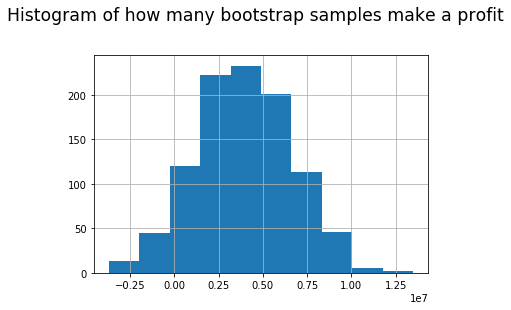

In [24]:
bs0 = bs_profit(target_test0, predicted_values0)


Wells that make a profit: 985
Proportion of wells that make a profit: 0.985


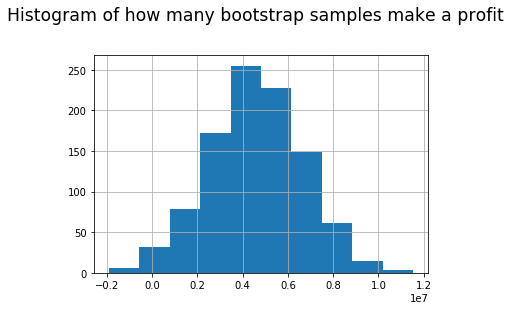

In [25]:
bs1 = bs_profit(target_test1, predicted_values1)


Wells that make a profit: 924
Proportion of wells that make a profit: 0.924


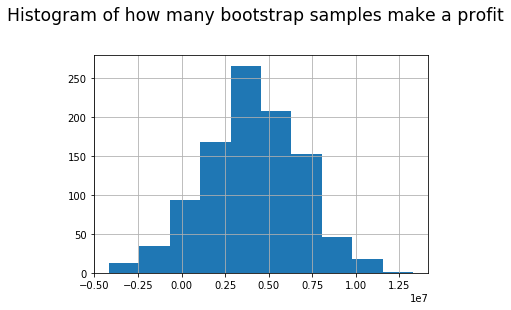

In [26]:
bs2 = bs_profit(target_test2, predicted_values2)



<div class="alert alert-block alert-success">
<b>Success:</b> Glad to see the visualization of results here.
</div>

The histograms above show us that it's highly unlikely for the developers to make a loss. The bootstrapping with 1000 iterations gives us good confidence since the resulting histogram looks like a nice curve that follows a normal distribution.
### Find average profit, 95% confidence interval and risk of losses. Loss is negative profit, calculate it as a probability and then express as a percentage.

The below function outputs the required. Initially I computed the confidence interval using the scipy library, but then I was told that the quantile method is more appropriate so I output that later.


In [31]:
conf_int(bs0)
bs_conf_int(bs0)


The average profit for this region is:  3961649.8480237112
The 95% confidence interval is: 3796203.1514797253 , 4127096.544567697
The risk of losses is 0.069
Confidence interval from the quantile method: -1112155.4589049604 , 9097669.415534232


In [32]:
conf_int(bs1)
bs_conf_int(bs1)


The average profit for this region is:  4560451.057866608
The 95% confidence interval is: 4431472.486639005 , 4689429.62909421
The risk of losses is 0.015
Confidence interval from the quantile method: 338205.0939898603 , 8522894.538660347


In [33]:
conf_int(bs2)
bs_conf_int(bs2)


The average profit for this region is:  4044038.6656835675
The 95% confidence interval is: 3874457.9747128035 , 4213619.356654331
The risk of losses is 0.076
Confidence interval from the quantile method: -1633504.1339559837 , 9503595.749237997


<div class="alert alert-block alert-success">
<b>Success:</b> Profit and risk of losses were calculated correctly. Good job!
</div>

### Provide findings: suggest a region for development of oil wells and justify the choice.
Surprisingly, the results we arrived at from bootstrapping are different from the one we go just from doing Linear Regression. This may be because the second region has a better R-squared value which means that it can consistently churn out profits while the first region can not.

## Conclusions
The quality of the models was evaluated and we got satisfactory R-squared metrics for each region's model. We found that the volume of reserves sufficient for developing a new well without losses is: 111.11. 

Bootstrapping gave us a better insight into the investment the company should make. All the regions have a good profit prediction. The risk of loss is lowest in the second region also, which means we there is a clear winner in the region we should dig 200 wells in.

<div class="alert alert-block alert-success">
<b>Success:</b> I agree with your choice!
</div>